In [1]:
#This implementation is based on Sarsa(lambda) algorithm from (http://www-anw.cs.umass.edu/~barto/courses/cs687/)


# https://deeplearningcourses.com/c/deep-reinforcement-learning-in-python
# https://www.udemy.com/deep-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
#
# Note: gym changed from version 0.7.3 to 0.8.0
# MountainCar episode length is capped at 200 in later versions.
# This means your agent can't learn as much in the earlier episodes
# since they are no longer as long.
#
# Adapt Q-Learning script to use TD(lambda) method instead

import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.linear_model import SGDRegressor

# code we already wrote
from q_learning import plot_cost_to_go, FeatureTransformer, plot_running_avg

In [7]:
class SubModel:
    def __init__(self, env, featureTransformer, lumda, learningRate, discount):
        self.env = env        
        self.ft = featureTransformer
        self.lumda = lumda
        self.learningRate = learningRate
        self.discount = discount
        
        #set size of the input vector
        X = self.ft.transform([env.observation_space.sample()])
        self.vSize = X.size       
        self.el = np.zeros(self.vSize)
        self.w = np.random.randn(self.vSize) / np.sqrt(self.vSize)
        
        #create a sub-model for each action
        self.actionSize  = env.action_space.n
        
    def predict(self, status):
        X = self.ft.transform([status])
        Y = X[0].dot(self.w)
        return Y
    
    def partial_fit(self, reward, oldStatus, newValue):
        oldValue = self.predict(oldStatus)
        X = self.ft.transform([oldStatus])
        self.el = self.lumda * self.discount * self.el + X[0]
        diff = reward + self.discount * newValue - oldValue
        self.w += self.learningRate * diff * self.el        

In [8]:
class Models:
    def __init__(self, env, featureTransformer, lumda, learningRate, discount):
        self.env = env        
        self.ft = featureTransformer     
           
        
        #create a sub-model for each action
        self.actionSize  = env.action_space.n
        self.models = []
        for i in range(self.actionSize):
            self.models.append(SubModel(env, featureTransformer, lumda, learningRate, discount))

    def update(self, reward, oldStatus, action, nextValue):        
        self.models[action].partial_fit(reward, oldStatus, nextValue)
        
    def predict(self, status): 
        results = np.stack([m.predict(status) for m in self.models])
        return results
    
    def sample_action(self, status, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(status))

In [9]:
def playOne(env, models, eps):
    oldObs = env.reset()   
    done = False    
    totalReward = 0
    i = 0
    while not done and i < 200:        
        action = models.sample_action(oldObs, eps)
        newObs, reward, done, info = env.step(action)
        totalReward += reward
        nextValue = np.max(models.predict(newObs))
        models.update(reward, oldObs, action, nextValue)
        oldObs = newObs
        i += 1
        
    return totalReward

In [18]:
def main():
    env = gym.make('MountainCar-v0')
    env.reset()
    ft = FeatureTransformer(env)    
    model = Models(env, ft, 0.9, 1e-2, 0.9999)
    N = 500
    totalRewards = np.empty(N)
    for n in range(N):
        eps = 0.1*(0.97**n)
        totalReward = playOne(env, model, eps)
        totalRewards[n] = totalReward
        print("episode:", n, "total reward:", totalReward)
        
    print("avg reward for last 100 episodes:", totalRewards[-100:].mean())
    print("total steps:", -totalRewards.sum())
    
    plt.plot(totalRewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalRewards)    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0 total reward: -200.0
episode: 1 total reward: -200.0
episode: 2 total reward: -200.0
episode: 3 total reward: -200.0
episode: 4 total reward: -200.0
episode: 5 total reward: -163.0
episode: 6 total reward: -200.0
episode: 7 total reward: -200.0
episode: 8 total reward: -200.0
episode: 9 total reward: -200.0
episode: 10 total reward: -200.0
episode: 11 total reward: -200.0
episode: 12 total reward: -200.0
episode: 13 total reward: -200.0
episode: 14 total reward: -200.0
episode: 15 total reward: -200.0
episode: 16 total reward: -142.0
episode: 17 total reward: -138.0
episode: 18 total reward: -200.0
episode: 19 total reward: -200.0
episode: 20 total reward: -200.0
episode: 21 total reward: -200.0
episode: 22 total reward: -153.0
episode: 23 total reward: -180.0
episode: 24 total reward: -132.0
episode: 25 total reward: -106.0
episode: 26 total reward: -139.0
episode: 27 total re

episode: 243 total reward: -116.0
episode: 244 total reward: -181.0
episode: 245 total reward: -200.0
episode: 246 total reward: -132.0
episode: 247 total reward: -165.0
episode: 248 total reward: -146.0
episode: 249 total reward: -133.0
episode: 250 total reward: -134.0
episode: 251 total reward: -126.0
episode: 252 total reward: -114.0
episode: 253 total reward: -144.0
episode: 254 total reward: -163.0
episode: 255 total reward: -130.0
episode: 256 total reward: -153.0
episode: 257 total reward: -156.0
episode: 258 total reward: -135.0
episode: 259 total reward: -136.0
episode: 260 total reward: -146.0
episode: 261 total reward: -135.0
episode: 262 total reward: -128.0
episode: 263 total reward: -126.0
episode: 264 total reward: -141.0
episode: 265 total reward: -180.0
episode: 266 total reward: -149.0
episode: 267 total reward: -128.0
episode: 268 total reward: -133.0
episode: 269 total reward: -133.0
episode: 270 total reward: -155.0
episode: 271 total reward: -135.0
episode: 272 t

episode: 485 total reward: -195.0
episode: 486 total reward: -135.0
episode: 487 total reward: -200.0
episode: 488 total reward: -137.0
episode: 489 total reward: -137.0
episode: 490 total reward: -135.0
episode: 491 total reward: -188.0
episode: 492 total reward: -185.0
episode: 493 total reward: -138.0
episode: 494 total reward: -200.0
episode: 495 total reward: -195.0
episode: 496 total reward: -180.0
episode: 497 total reward: -150.0
episode: 498 total reward: -135.0
episode: 499 total reward: -141.0
avg reward for last 100 episodes: -151.66
total steps: 70968.0


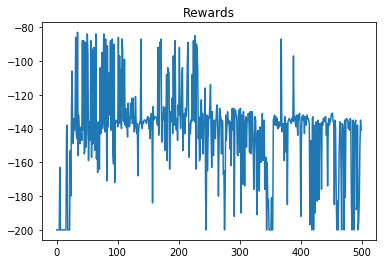

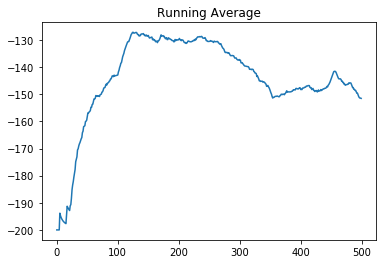

In [19]:
main()